### ASTR 3300/5300-003: Astrostatistics
***N. Pol***
___

# Homework 4
### Due: Friday, Feb 21st at 11.59pm CST
---

## Problem 1

This problem uses a dataset in `/coursework/homeworks/hw_data/`.

1) Read in `hw4_data_1.npy`. This is a (10 x 2) numpy array, with voltage measurements in the first column and heteroscedastic voltage uncertainties in the second column. Compute the sample mean and the standard error on the sample mean for this data.

2) Fit the appropriate ln-likelihood function and find the best-fit mean voltage.

3) Compute and plot the Bayesian posterior probability density (*not the log posterior*) for the mean voltage assuming a uniform prior for the mean in the range 3 to 7. Make sure this posterior pdf is normalized!

4) By either drawing samples from this posterior, or using your gridded posterior pdf to make a cdf, find the equal-tailed 68.3% credible region for the mean, and compare the upper and lower boundaries to the sample mean plus/minus the standard error, respectively. *Also* find the MAP value of the mean.

5) Repeat (3) and (4) this time with a prior on the mean that is uniform in the range 4.6 to 5.4. 

6) Now, imagine that we read an old paper about the experiment that gave us the voltage measurements, and they found that the mean was actually $6\pm0.3$. Repeat (3) and (4) this time with a Gaussian prior on the mean centered at $6$ with standard deviation of $0.3$.

7) Plot all of the normalized posterior pdfs for $\mu$ from (3), (5), and (6) on the same plot, making sure that the xlim of the plot spans 0 to 10.

8) You have made sure that the posterior pdfs are properly normalized, but until now you have ignored the meaning of that normalization constant. It is the Bayesian evidence for the particular model you have applied! Compute the evidence under a new model where the prior for the mean is a delta function at the best-fit value you found in (1) *(think about this and don't just immediately go looking for a `scipy.stats` delta function)*. Compare this to the evidence found under the prior in (3). Taking ratios to make a Bayes factor, which model is favored? Is there much of an Occam penalty by having the wide prior compared to knowing the mean exactly? 

### Solution

In [31]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
from scipy.optimize import minimize
from scipy.stats import norm
%config InlineBackend.figure_format='retina'

# Analytical and Best Fit result

In [148]:
# First a little check on from what distribution the data could be
data = np.load('./hw_data/hw4_data_1.npy')
V = data[:,0]
dV = data[:,1]
print("Sample Mean:",np.mean(V))
print("Mean of dV:",np.mean(dV))
#Since, mean >> variance, I am not assuming this as a Poissonian distribution, but going ahead with a Gaussian distribution
sigma_mu_an = 1/np.sqrt(np.sum(1/dV**2))         # Analytical Error on mu
print("Sample Error on Mean:", np.round(sigma_mu_an,3))

Sample Mean: 5.106
Mean of dV: 1.579
Sample Error on Mean: 0.43


In [141]:
# defining the function for minimize
def nlnL(mu0,x_i,err): # Assuming standard error instead of Hetro error
    return 0.5*np.log(2*np.pi*err**2) + np.sum((x_i-mu0)**2/(2*err**2))
    # used the negative likelihood for minimization procedure
   
best_fit = minimize(nlnL,np.mean(V), args=(V,sigma_mu_an)) # took simple np.mean(x) as the starting point

mu_num = best_fit.x[0]
print("Best Fit Mean (Standard Error on Sample Mean):", np.round(mu_num,3))

# defining the function for minimize
def nlnL(mu0,x_i,err_i): # assuming hetro errors
    return 0.5*np.log(2*np.pi) + np.sum(np.log(err_i) + (x_i-mu0)**2/(2*err_i**2))
    # used the negative likelihood for minimization procedure
   
best_fit = minimize(nlnL,np.mean(V), args=(V, dV)) # took simple np.mean(x) as the starting point

mu_num = best_fit.x[0]
print("Best Fit Mean (Hetro errors):", np.round(mu_num,3))

Best Fit Mean (Standard Error on Sample Mean): 5.106
Best Fit Mean (Hetro errors): 4.942


# Bayesian Analysis

$${\rm Posterior \,\, Probability} = \frac{{\rm Likelihood}\times{\rm Prior}}{{\rm Evidence}}.$$

Likelihood is:

$$L = p(\{x_i\}|\mu,I) = \prod_{i=1}^N \frac{1}{\sigma_i\sqrt{2\pi}} \exp\left(\frac{-(x_i-\mu)^2}
{2\sigma_i^2}\right).$$

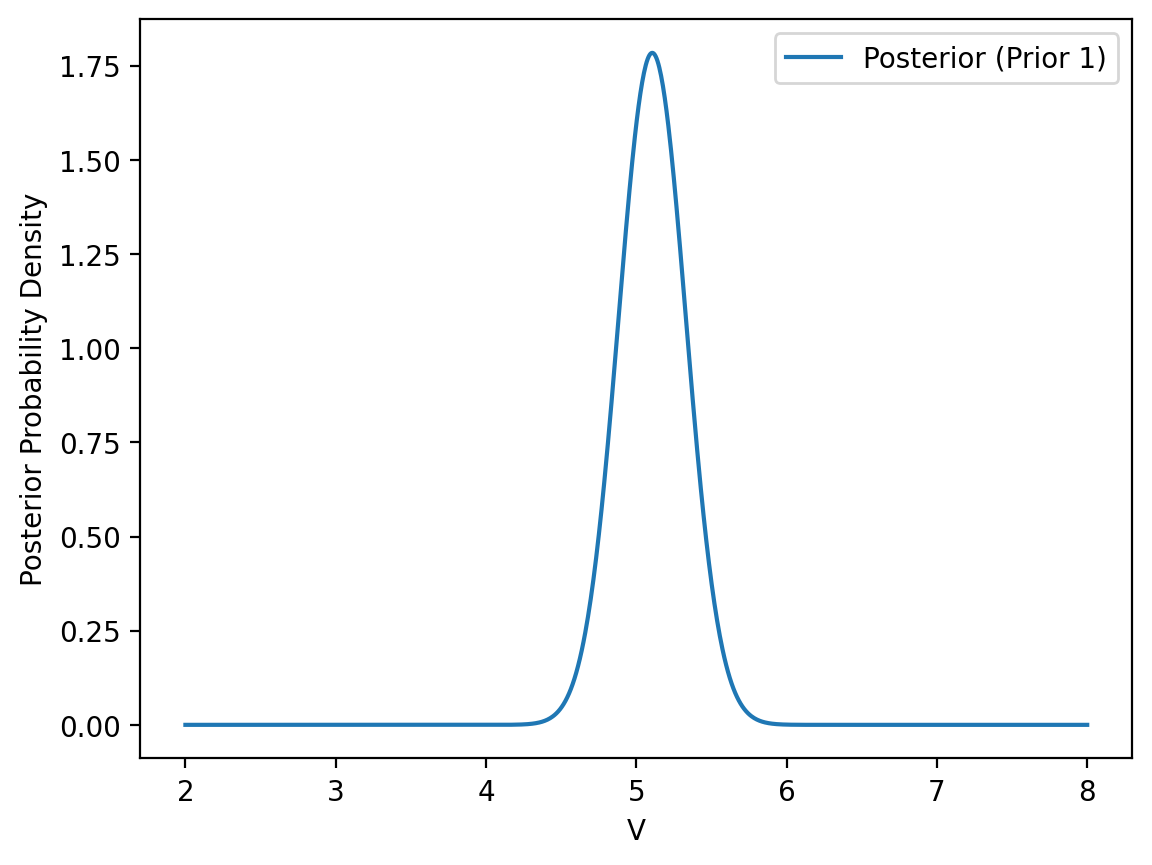

In [187]:
# Getting Posterior
muGrid = np.linspace(2,8,1000)

def L(mu,V,dV):
    return np.prod(np.exp(-(V-mu)**2)/(2*dV**2)/(np.sqrt(dV**2*2*np.pi))) # Likelihood for Hetro Gauss

def prior(mu):
    if 3<=mu<=7:
        return 1 # a uniform prior
    else:
        return 0

def posterior(mu,V,dV):
    return L(mu,V,dV)*prior(mu) # Posterior = Likelihood x Prior # Evidence = 1

posterior_vals = []
for mu in muGrid:
    posterior_val = posterior(mu,V,dV)
    posterior_vals.append(posterior_val)

area_posterior = np.trapz(posterior_vals, muGrid) # to normalise posterior, find the total area
posterior_vals = posterior_vals/area_posterior    # divide posterior by total area

posterior1 = posterior_vals

plt.plot(muGrid, posterior_vals, label='Posterior (Prior 1)')
plt.xlabel("V")
plt.ylabel("Posterior Probability Density")
plt.legend()
plt.show()

MAP =  5.105
Lower 68% =  4.883
Upper 68% =  5.327


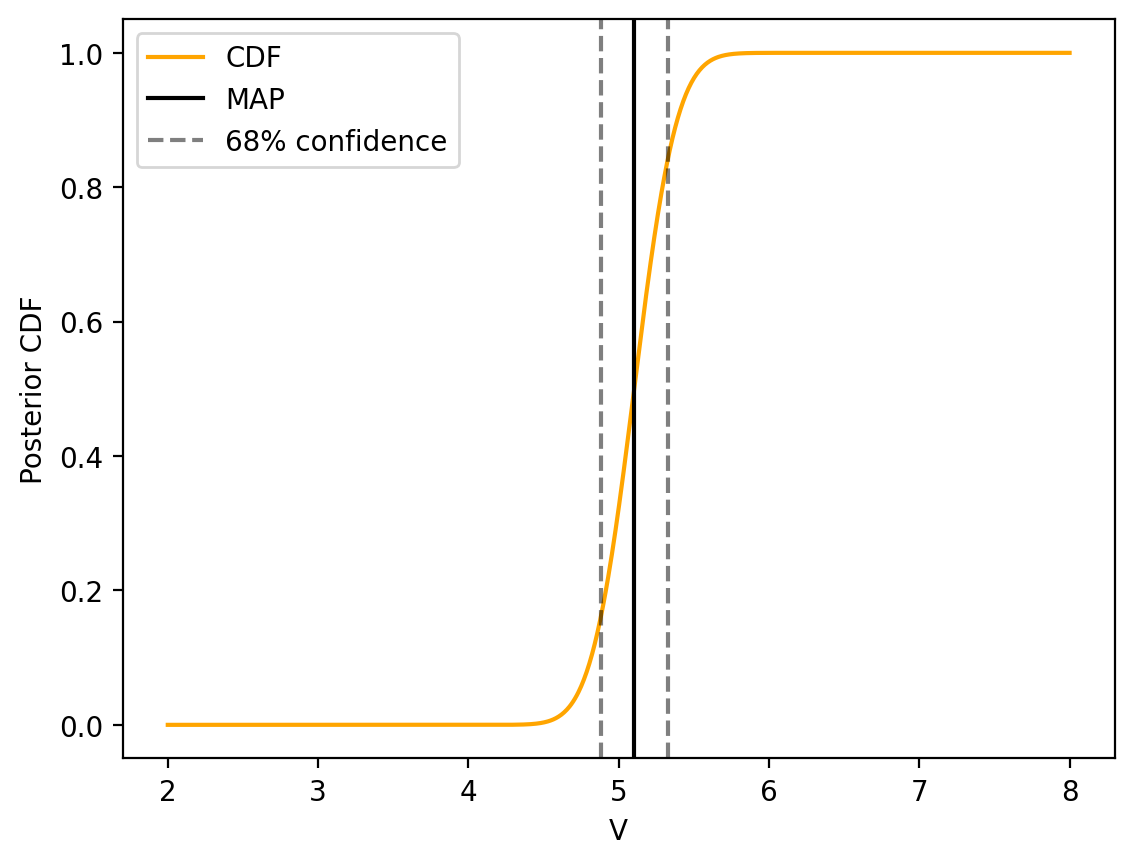

In [188]:
# Getting CDF
MAP = muGrid[np.argmax(posterior_vals)] # Maximum Posterior value (Mean) is at MAP

cdf = np.cumsum(posterior_vals)/np.sum(posterior_vals) # Normalised CDF

# We will integrate downwards till (1-X)/2% to find X% Confidence Interval values
l_confidence = muGrid[np.where(cdf >= (1-0.683)/2)[0][0]] # Find the V value for Cumulative sum is just more than (1-0.683)/2
u_confidence = muGrid[np.where(cdf >= (1+0.683)/2)[0][0]] # Find the V value for Cumulative sum is just more than (1+0.683)/2

print("MAP = ", np.round(MAP,3))
print("Lower 68% = ", np.round(l_confidence,3))
print("Upper 68% = ", np.round(u_confidence,3))

plt.plot(muGrid,cdf,label="CDF",color='orange')
plt.axvline(MAP, color='black',label="MAP")
plt.axvline(l_confidence,ls='--', color='black',label="68% confidence",alpha=0.5)
plt.axvline(u_confidence,ls='--', color='black',alpha=0.5)
plt.xlabel("V")
plt.ylabel("Posterior CDF")
plt.legend()
plt.show()

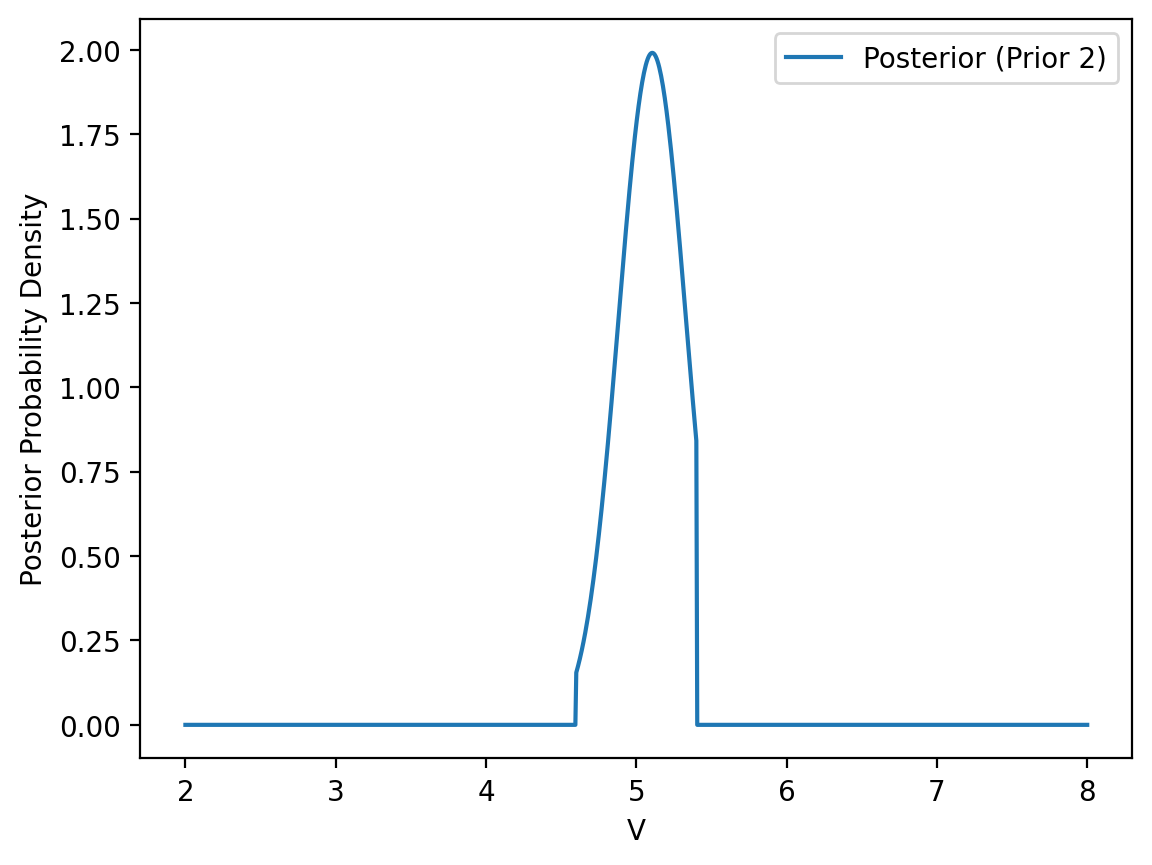

In [189]:
# With different prior

# Getting Posterior
muGrid = np.linspace(2,8,1000)

def L(mu,V,dV):
    return np.prod(np.exp(-(V-mu)**2)/(2*dV**2)/(np.sqrt(dV**2*2*np.pi))) # Likelihood for Hetro Gauss

def prior(mu):
    if 4.6<=mu<=5.4:
        return 1 # a uniform prior
    else:
        return 0

def posterior(mu,V,dV):
    return L(mu,V,dV)*prior(mu) # Posterior = Likelihood x Prior # Evidence = 1

posterior_vals = []
for mu in muGrid:
    posterior_val = posterior(mu,V,dV)
    posterior_vals.append(posterior_val)

area_posterior = np.trapz(posterior_vals, muGrid) # to normalise posterior, find the total area
posterior_vals = posterior_vals/area_posterior    # divide posterior by total area

posterior2 = posterior_vals
plt.plot(muGrid, posterior_vals, label='Posterior (Prior 2)')
plt.xlabel("V")
plt.ylabel("Posterior Probability Density")
plt.legend()
plt.show()

MAP =  5.105
Lower 68% =  4.877
Upper 68% =  5.267


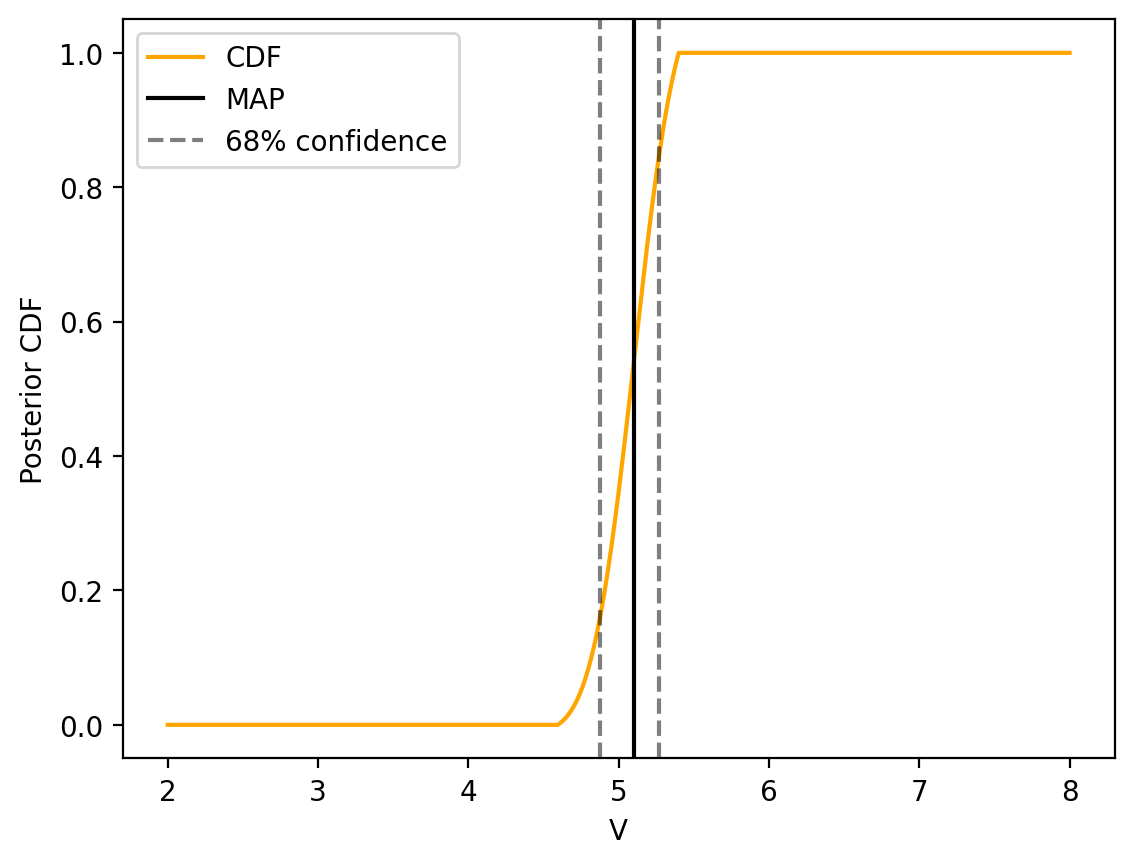

Map value remains the same but confidence interval values change


In [190]:
# Getting CDF
MAP = muGrid[np.argmax(posterior_vals)] # Maximum Posterior value (Mean) is at MAP

cdf = np.cumsum(posterior_vals)/np.sum(posterior_vals) # Normalised CDF

# We will integrate downwards till (1-X)/2% to find X% Confidence Interval values
l_confidence = muGrid[np.where(cdf >= (1-0.683)/2)[0][0]] # Find the V value for Cumulative sum is just more than (1-0.683)/2
u_confidence = muGrid[np.where(cdf >= (1+0.683)/2)[0][0]] # Find the V value for Cumulative sum is just more than (1+0.683)/2

print("MAP = ", np.round(MAP,3))
print("Lower 68% = ", np.round(l_confidence,3))
print("Upper 68% = ", np.round(u_confidence,3))

plt.plot(muGrid,cdf,label="CDF",color='orange')
plt.axvline(MAP, color='black',label="MAP")
plt.axvline(l_confidence,ls='--', color='black',label="68% confidence",alpha=0.5)
plt.axvline(u_confidence,ls='--', color='black',alpha=0.5)
plt.xlabel("V")
plt.ylabel("Posterior CDF")
plt.legend()
plt.show()

print("Map value remains the same but confidence interval values change")

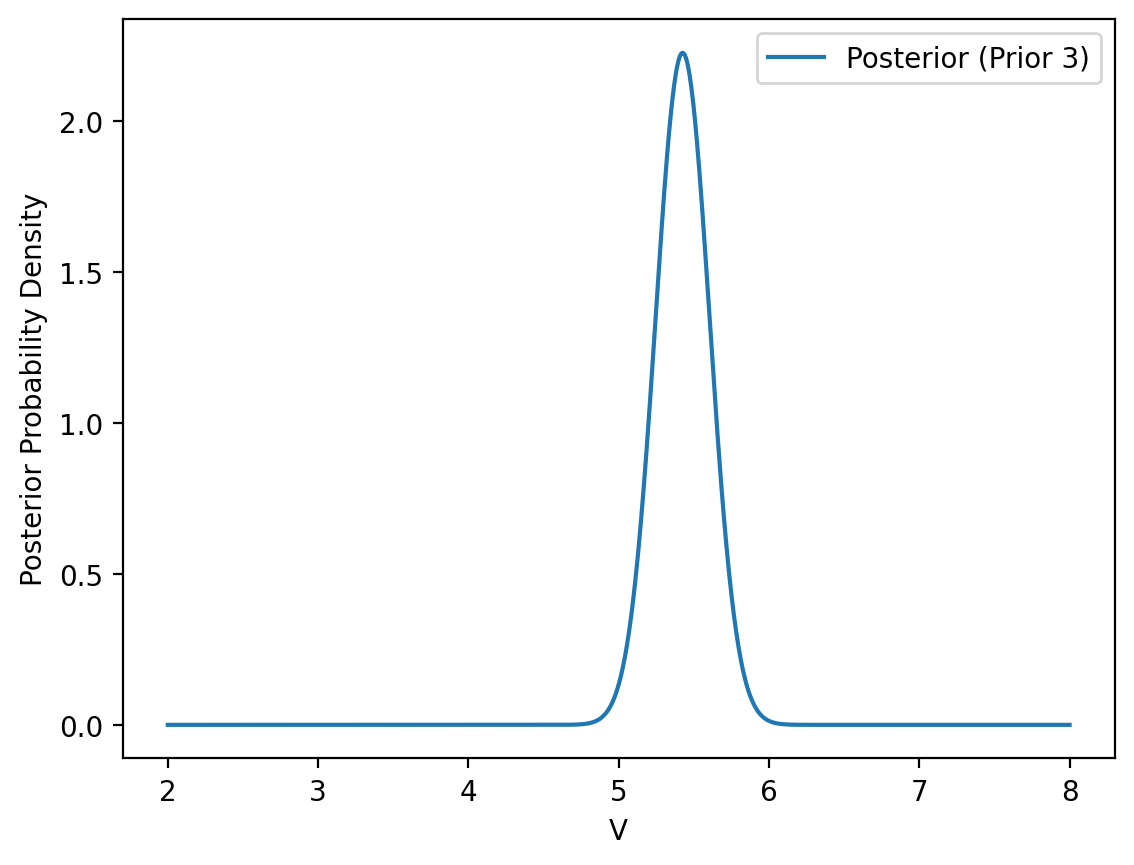

In [191]:
# New Prior Gaussian with mean = 6 pm 0.3

# With different prior

# Getting Posterior
muGrid = np.linspace(2,8,1000)

def L(mu,V,dV):
    return np.prod(np.exp(-(V-mu)**2)/(2*dV**2)/(np.sqrt(dV**2*2*np.pi))) # Likelihood for Hetro Gauss

def prior(mu):
    return norm.pdf(mu,loc=6.0,scale=0.3)

def posterior(mu,V,dV):
    return L(mu,V,dV)*prior(mu) # Posterior = Likelihood x Prior # Evidence = 1

posterior_vals = []
for mu in muGrid:
    posterior_val = posterior(mu,V,dV)
    posterior_vals.append(posterior_val)
    

area_posterior = np.trapz(posterior_vals, muGrid) # to normalise posterior, find the total area
posterior_vals = posterior_vals/area_posterior    # divide posterior by total area

posterior3 = posterior_vals
plt.plot(muGrid, posterior_vals, label='Posterior (Prior 3)')
plt.xlabel("V")
plt.ylabel("Posterior Probability Density")
plt.legend()
plt.show()

MAP =  5.423
Lower 68% =  5.243
Upper 68% =  5.604


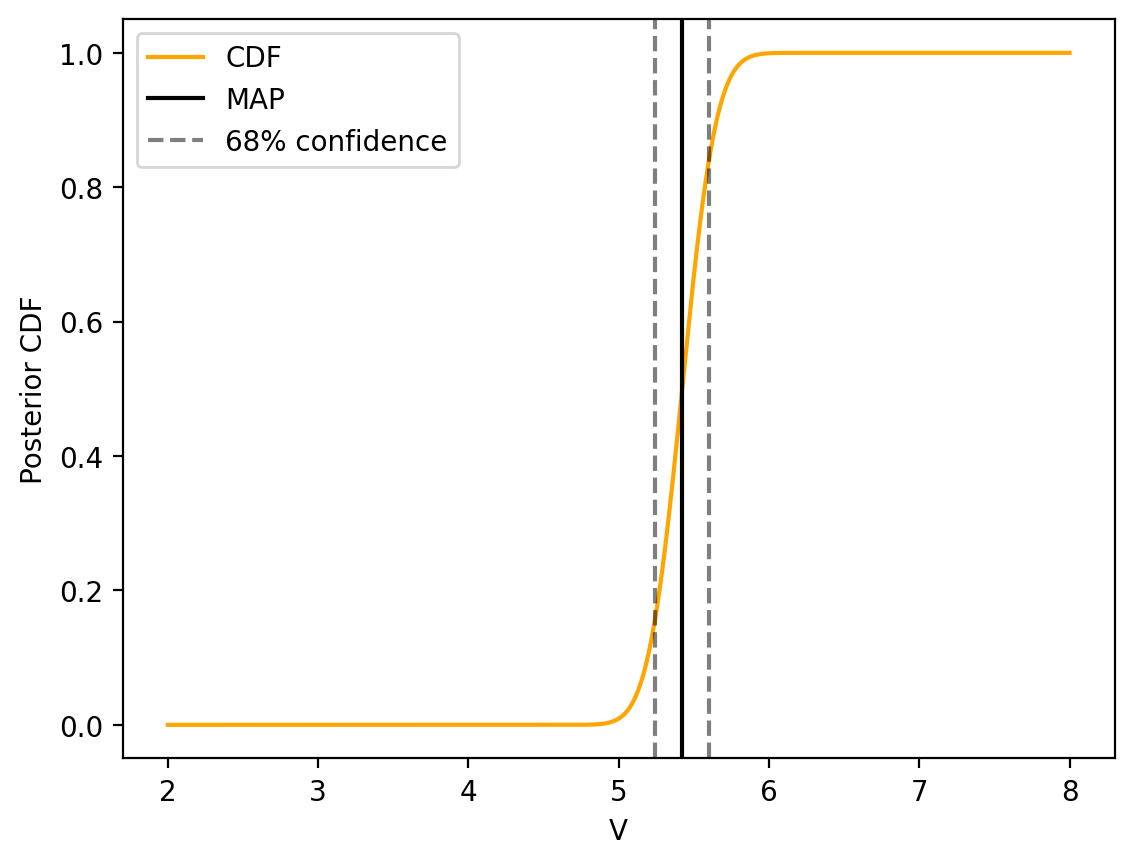

Map value and CI change


In [192]:
# Getting CDF
MAP = muGrid[np.argmax(posterior_vals)] # Maximum Posterior value (Mean) is at MAP

cdf = np.cumsum(posterior_vals)/np.sum(posterior_vals) # Normalised CDF

# We will integrate downwards till (1-X)/2% to find X% Confidence Interval values
l_confidence = muGrid[np.where(cdf >= (1-0.683)/2)[0][0]] # Find the V value for Cumulative sum is just more than (1-0.683)/2
u_confidence = muGrid[np.where(cdf >= (1+0.683)/2)[0][0]] # Find the V value for Cumulative sum is just more than (1+0.683)/2

print("MAP = ", np.round(MAP,3))
print("Lower 68% = ", np.round(l_confidence,3))
print("Upper 68% = ", np.round(u_confidence,3))

plt.plot(muGrid,cdf,label="CDF",color='orange')
plt.axvline(MAP, color='black',label="MAP")
plt.axvline(l_confidence,ls='--', color='black',label="68% confidence",alpha=0.5)
plt.axvline(u_confidence,ls='--', color='black',alpha=0.5)
plt.xlabel("V")
plt.ylabel("Posterior CDF")
plt.legend()
plt.show()

print("Map value and CI change")

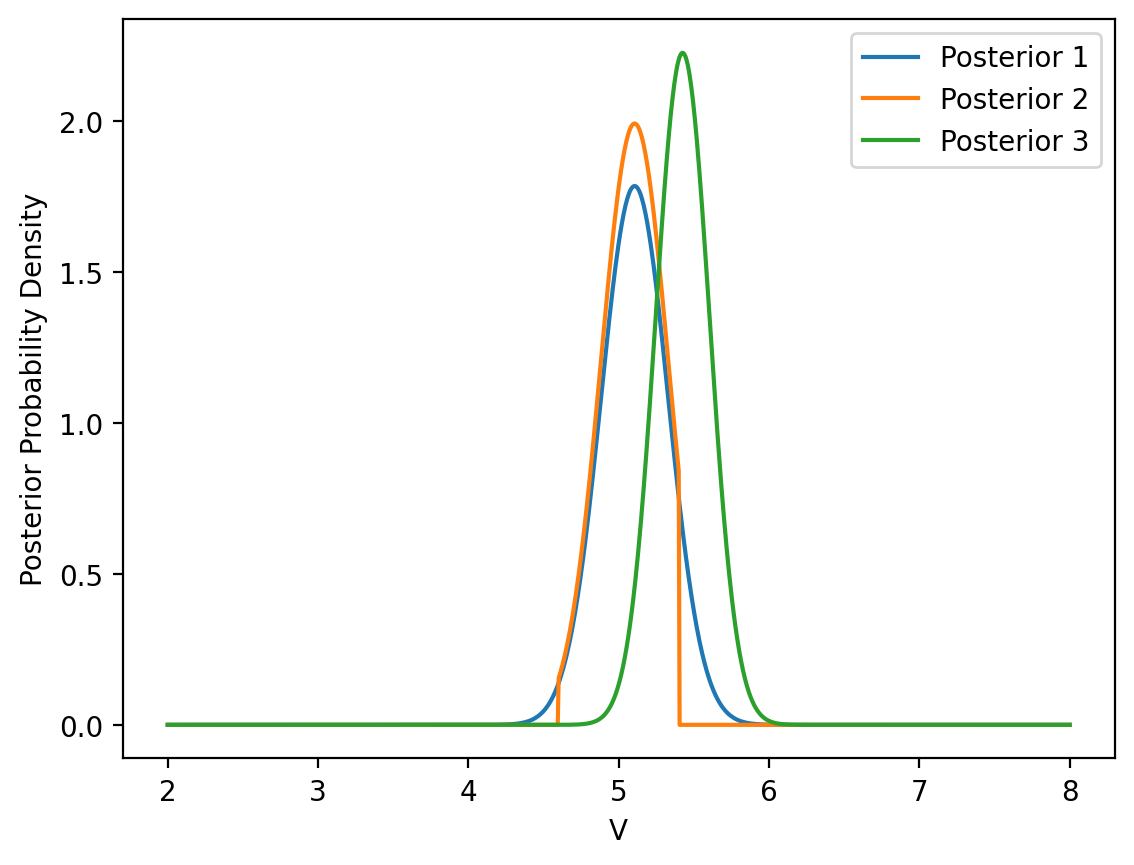

In [196]:
# All three Posteriors
plt.plot(muGrid,posterior1,label="Posterior 1")
plt.plot(muGrid,posterior2,label="Posterior 2")
plt.plot(muGrid,posterior3,label="Posterior 3")
plt.xlabel("V")
plt.ylabel("Posterior Probability Density")
plt.legend()
plt.show()

## Problem 2

This problem uses a dataset in `/coursework/homeworks/hw_data/`.

1) Read in `hw4_data_2.npy`, which is a (3 x 20) numpy array that you used in `Lecture_9`. Set `x, y, sigma_y = data`. 

We're going to do some polynomial fits to this data just like in `Lecture 9`. However, in all cases you should **keep the $y$-intercept fixed at $-0.23$**. 

2) Use the following code to compute the un-normalized posterior pdf (i.e. just the likelihood x prior) on a grid of the linear coefficient (i.e. the slope) of a linear model, with a uniform prior between 0.5 and 1.5. Plot this posterior pdf. Remember this is just a one-dimensional model because the $y$-intercept is fixed. I advise a grid size of 100.

In [202]:
#Functions to do a polynomial fit, and compute the likelihood
def polynomial_fit(theta, x):
    """Polynomial model of degree (len(theta) - 1)"""
    # For a polynomial with order 1, this gives theta_0 + theta_1*x
    # For a polynomial with order 2, this gives theta_0 + theta_1*x + theta_2*x^2, etc.
    return sum(t * x ** n for (n, t) in enumerate(theta))

# compute the data log-likelihood given a model
def logL(theta, data, model=polynomial_fit):
    """Gaussian log-likelihood of the model at theta"""
    x, y, sigma_y = data
    y_fit = model(theta, x)
    return sum(scipy.stats.norm.logpdf(*args) 
               for args in zip(y, y_fit, sigma_y))

def prior(theta):
    # uniform prior for slope between 0.5 and 1.5
    slope = theta[1]
    if 0.5<=slope<=1.5:
        return 1 # a uniform prior
    else:
        return 0

def posterior(theta,data):
    return np.exp(logL(theta, data))*prior(theta) # isntead of log L, use exp(logL)

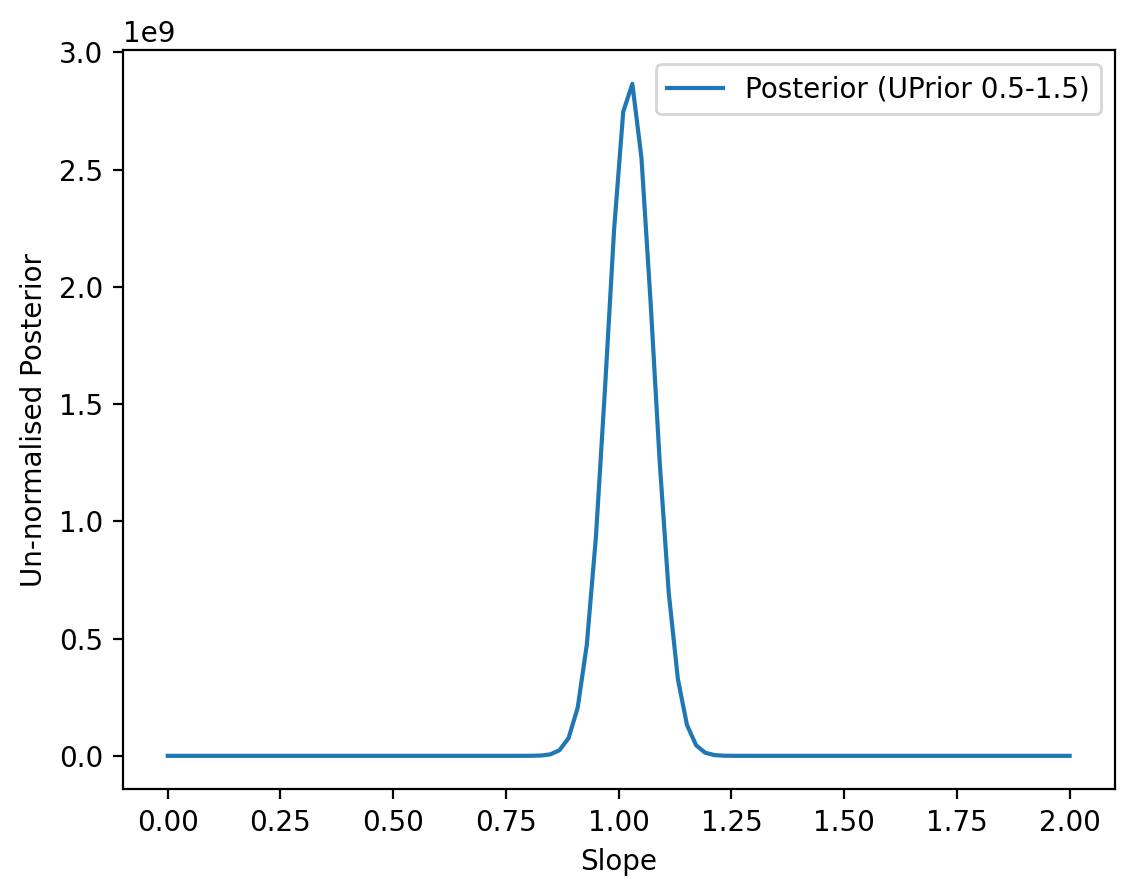

In [210]:
x, y, sigma_y = np.load('hw_data/hw4_data_2.npy')

posterior_vals = []
slopeGrid = np.linspace(0,2,100)
for slope in slopeGrid:
    theta_0 = -0.23 # Fixed y-intercept
    theta = np.array([theta_0, slope])
    posterior_val = posterior(theta, (x, y, sigma_y))
    posterior_vals.append(posterior_val)

plt.plot(slopeGrid, posterior_vals, label='Posterior (UPrior 0.5-1.5)')
plt.xlabel('Slope')
plt.ylabel('Un-normalised Posterior')
plt.legend()
plt.show()

3) Using your 1D gridded likelihood-x-prior, compute the Bayesian evidence of this linear model. This may be a big number!

4) Now compute the joint 2D posterior pdf (again just the likelihood x prior) of linear and quadratic coefficients of a quadratic model. Give the linear coefficient a uniform prior between 0.5 and 1.5. Give the quadratic coefficient a uniform prior between -1 and 0.25. Plot this two-dimensional posterior. Remember this is a two-dimensional model because the $y$-intercept is fixed. I advise a grid size of 100 in each model dimension.

5) Using your 2D gridded likelihood-x-prior, compute the Bayesian evidence of the quadratic model. 

6) Calculate the Bayes factor for a linear versus quadratic model. How does this compare/contrast with the BIC model comparison in the lecture? 

### Solution